In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gym
from IPython.core.display_functions import clear_output
from matplotlib import pyplot as plt

from agents.cDDQN_pytorch import DQNLoadedPolicy, DDQN_torch
from agents.cRainbow_pytorch import *

from environments_and_constraints.lunar_lander.utils import *

## Helper Functions:

In [3]:
def sliding_average(values, w=5):
    '''
    Function for smoothing an array using a sliding average
    
    Parameters:
    ----------
    values (array-like): Values to smooth
    w (int): Window of values to smooth over
    '''
    if w == 0:
        return np.array(values)
    else:
        new_values = []
        for i in range(len(values)):
            new_values.append(np.mean(values[max(i - w, 0): min(i + w + 1, len(values))]))
        return np.array(new_values)


def plot_training(episode,rewards,losses):
    """Plot the training progress."""
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title('episode %s. rewards: %s' % (episode, np.mean(rewards[-10:])))
    if len(rewards) > 40:
        plt.plot(sliding_average(rewards, w=30))
    else:
        plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    if len(losses) > 40:
        plt.plot(sliding_average(losses, w=30))
    else:
        plt.plot(losses)
    plt.show()

In [4]:
def run_episode_experiment(env, agent, train=True, log_r = False):
    '''
    Runs a single episode
    
    Parameters:
    ----------
    env: environment, should contain the functions reset and step
    agent: rl learning agent, should contain the functions get_action, add_experience_train, and end_episode
    train (bool): whether to train the agent (set to False to evaluate)
    log_r (bool): use the log of rewards to train
    '''
    state = env.reset()
    total_reward = 0
    total_loss = 0
    all_rewards = []
    all_rewards_unscaled = []
    t = 0
    done = False
    while not done:
        t+= 1
        if train:
            eps = None
        else:
            eps = EPS_MIN
        action = agent.get_action(state, eps)
        next_state, reward_unscaled, done, info = env.step(action)
        
        if log_r:
            if reward_unscaled < 1:
                reward = -10
            else:
                reward = np.log(reward_unscaled) - 10
        else:
            reward = reward_unscaled
            
        if train:
            loss = agent.add_experience_train(state, action, reward, next_state, done)
            total_loss += loss

        state = next_state
        total_reward += reward
        all_rewards.append(reward)
        all_rewards_unscaled.append(reward_unscaled)
        if done:
            break

    return total_reward, total_loss, all_rewards, all_rewards_unscaled, t

In [5]:
def run_experiment(env, agent, n_episodes = 5000, log_r = False):
    '''
    Runs the episode and plots the progress
    
    Parameters:
    ----------
    env: environment, should contain the functions reset and step
    agent: rl learning agent, should contain the functions get_action, add_experience_train, and end_episode
    n_episodes (int): number of episodes to run
    log_r (bool): use the log of rewards to train
    '''
    rewards = []
    rewards_unscaled = []
    losses = []
    for n in range(n_episodes):
        total_reward, total_loss, all_rewards, all_rewards_unscaled, t = run_episode_experiment(env, agent, train=True, log_r = log_r)
        removed_constraint = agent.end_episode(total_reward)
        if removed_constraint is not None:
            print(n, removed_constraint)
        rewards.append(sum(all_rewards_unscaled))
        losses.append(total_loss)
        plot_training(n, np.array(rewards), np.array(losses))

# Experiments

Below contains the parameters for running the experiments.

agent_params contains a dictionary of parameters for the base learning agents (ex. DDQN, Rainbow, etc) see the implementation file in the agents directory for detailed description of parameters.

csrl_params contains a dictionary of parameters for the CSRL meta-selection agent, see the implementation file in the agents directory for details description of parameters.


## Lunar Lander

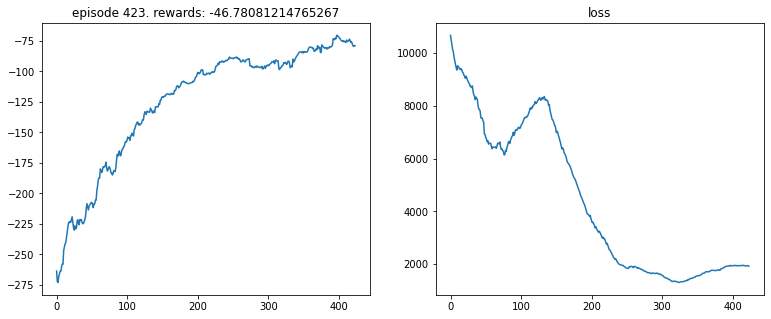

In [ ]:
seed = 0  # Set the random seed

torch.manual_seed(seed)

device = torch.device(f'cuda:{int(0)}' if torch.cuda.is_available() else 'cpu')
folder = '../environments_and_constraints/lunar_lander/trained_agent_files/'
state_size = 8
action_size = 4

# Make the environment
env = gym.make('LunarLander-v2')
env.seed(seed)

# Create the constraints
# Load in the "human" policies that we use as constraints
policies_dict = {key: DQNLoadedPolicy(state_size, action_size,
                                      filename=folder + save_model_paths[key],
                                      device=device)
                 for key in policies_needed}
constraints_names = ['none', 'p0_1', 'p1_1', 'p2_1', 'p3_1', 'p4_1', 'p5_1', 'p6_1', 'p7_1', 'p01_1', 'p23_1', 'p45_1',
                     'p67_1']
constraint_func_list, epsilon_decay_list, more_constrained_constraints_list, less_constrained_constraints_list \
    = get_info(constraints_names, constraint_name_to_lists, epsilon_decays, more_constrained_constraints,
               less_constrained_constraints, policies_dict)

# Set the params of the base learning agent
agent_params = {
    'state_size': state_size,
    'action_size': action_size,
    'device': device,
    'gamma': 0.99,
    'max_buffer_size': int(1e5),
    'batch_size': 64,
    'lr': 1e-3,
    'copy_param': 4,
    'double': True,
    'epsilon_init': 1,
    'decay_epsilon_experience': True
}
# agent_type selects the learner to use:
constraint_func = constraint_func_list[0]
epsilon_decay = epsilon_decay_list[0]
print(constraint_func)
print('-------')
print(epsilon_decay)
agent = DDQN_torch(constraint_func=constraint_func, epsilon_decay=epsilon_decay, **agent_params)
run_experiment(env, agent, n_episodes=5000, log_r=False)